In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Masking # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras import regularizers # type: ignore
import json
import datetime

# Local imports
from src.data_processing.lstm_data_preprocessing import reduce_time_bucket_features, FeaturesConfig
from src.data_processing.loader import load_time_bucket_data

2025-04-18 15:37:43.674671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744987063.705120   35334 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744987063.714170   35334 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744987063.753572   35334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744987063.753638   35334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744987063.753641   35334 computation_placer.cc:177] computation placer alr

In [3]:
# Define configs
features_config = FeaturesConfig(
        trade_size_ratio=True,
        liquidity_ratio=True,
        relative_time=True,
        price_change=True,
    )

test_size = 0.2

In [4]:
# Generate train - test data

X_scaler = StandardScaler()
y_scaler = StandardScaler()

time_bucket_folder = "time_bucket_1"  # Change based on which time bucket configuration you want to used, their preprocessed in different folders
token_time_buckets, time_bucket_config = load_time_bucket_data(time_bucket_folder)

token_datasets = []
for token_address, data in token_time_buckets.items():
    X = data["X"]
    y = data["y"]
    bucket_times = data["bucket_times"]

    # Only get the features listed in features_config
    X = reduce_time_bucket_features(X, features_config)

    token_datasets.append((X, y, token_address, bucket_times))

# Combine all token data
all_X = np.vstack([data[0] for data in token_datasets])
all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])

# Scale features
num_samples, time_steps, features = all_X.shape
X_reshaped = all_X.reshape(num_samples * time_steps, features)
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale target variable also using StandardScaler to preserve direction
y_scaled = y_scaler.fit_transform(all_y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, shuffle=False)

In [5]:
# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

epochs = 100
batch_size = 32

# Model definition
model = Sequential()

# Masking layer for the padded values
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))

# Input + first LSTM layer
model.add(Bidirectional(
    LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))
))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second LSTM
model.add(Bidirectional(
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))
))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense output layer
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss=weighted_mse_large_moves)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


/home/maked/CM3203-Project/CM3203-Venv/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1744987092.593046   35334 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4993 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:08:00.0, compute capability: 8.9
2025-04-18 15:38:21.602724: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320812800 exceeds 10% of free system memory.
2025-04-18 15:38:23.015094: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 320812800 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1744987111.318954   35513 cuda_dnn.cc:529] Loaded cuDNN version 90300


2089/2089 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 4.2878

2025-04-18 15:42:16.781568: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80203200 exceeds 10% of free system memory.
2025-04-18 15:42:16.851534: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80203200 exceeds 10% of free system memory.


2089/2089 ━━━━━━━━━━━━━━━━━━━━ 261s 121ms/step - loss: 4.2877 - val_loss: 9.7282
Epoch 2/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 268s 128ms/step - loss: 3.8057 - val_loss: 5.0657
Epoch 3/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 255s 122ms/step - loss: 3.9365 - val_loss: 4.3429
Epoch 4/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 233s 111ms/step - loss: 3.7409 - val_loss: 4.6232
Epoch 5/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 227s 109ms/step - loss: 3.5976 - val_loss: 4.4293
Epoch 6/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 231s 111ms/step - loss: 3.5898 - val_loss: 4.1154
Epoch 7/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 230s 110ms/step - loss: 3.8977 - val_loss: 4.1249
Epoch 8/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 234s 112ms/step - loss: 3.4929 - val_loss: 4.5703
Epoch 9/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 240s 115ms/step - loss: 3.4623 - val_loss: 4.3545
Epoch 10/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 235s 112ms/step - loss: 3.9911 - val_loss: 4.4689
Epoch 11/100
2089/2089 ━━━━━━━━━━━━━━━━━━━━ 231s 111ms/step - loss: 3.4079 - val_

In [6]:
# Save model

# Create a directory to save all model artifacts
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
base_dir = "trained_models"
model_name = f"lstm_{len(os.listdir(base_dir)) + 1}"
model_dir = os.path.join(base_dir, model_name)
os.makedirs(model_dir, exist_ok=True)

# 1. Save the Keras model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)
print(f"Model saved to {model_path}")


# 2. Save configuration parameters
# Get optimizer and loss function from model.compile
optimizer_name = model.optimizer.__class__.__name__.lower()
loss_name = model.loss.__name__ if callable(model.loss) else model.loss

# Extract model layers information
model_layers = []
for layer in model.layers:
    layer_config = {
        "name": layer.name,
        "type": layer.__class__.__name__
    }
    
    # Add units if available (for LSTM and Dense layers)
    if hasattr(layer, "units"):
        layer_config["units"] = layer.units
        
    # Add activation if available
    if hasattr(layer, "activation") and layer.activation is not None:
        if hasattr(layer.activation, "__name__"):
            layer_config["activation"] = layer.activation.__name__
        else:
            layer_config["activation"] = str(layer.activation)
            
    # Add dropout rate if applicable
    if hasattr(layer, "rate"):
        layer_config["rate"] = layer.rate
        
    # Try to get output shape from layer.output if it exists
    try:
        if hasattr(layer, "output") and layer.output is not None:
            output_shape = layer.output.shape.as_list()
            layer_config["output_shape"] = [dim if dim is not None else -1 for dim in output_shape]
    except (AttributeError, ValueError):
        # Skip output shape if it causes an error
        pass
        
    model_layers.append(layer_config)

# Create configuration dictionary with all parameters used
config = {
    "features_config": vars(features_config),  # Convert class to dict
    "time_bucket_folder": time_bucket_folder,
    "test_size": test_size,
    "training_params": {
        "optimizer": optimizer_name,
        "loss": loss_name,
        "epochs": epochs,
        "batch_size": batch_size,
        "validation_split": None,
        "early_stopping": {
            "monitor": early_stopping.monitor,
            "patience": early_stopping.patience,
            "min_delta": early_stopping.min_delta,
            "mode": early_stopping.mode,
            "restore_best_weights": early_stopping.restore_best_weights
            }
    },
    "model_architecture": {
        "layers": model_layers,
        "total_params": model.count_params()
    },
    "timestamp": timestamp,
    "input_shape": [dim if dim is not None else -1 for dim in model.input_shape],  # Save input shape
    "X_train_shape": list(X_train.shape),
    "y_train_shape": list(y_train.shape)
}

config_path = os.path.join(model_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)
print(f"Configuration saved to {config_path}")
print(f"\nAll model artifacts saved to {model_dir}")

Model saved to trained_models/lstm_8/model.keras
Configuration saved to trained_models/lstm_8/config.json

All model artifacts saved to trained_models/lstm_8


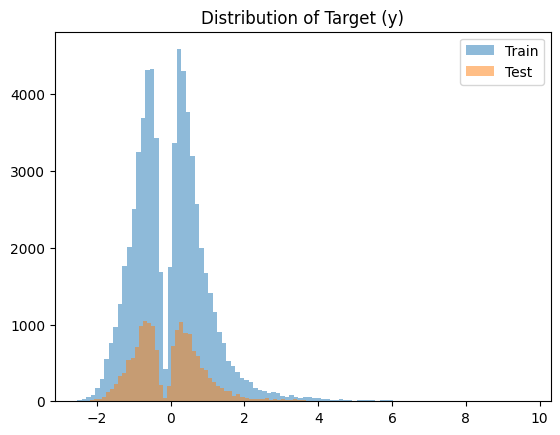

In [7]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=100, alpha=0.5, label="Train")
plt.hist(y_test, bins=100, alpha=0.5, label="Test")
plt.legend()
plt.title("Distribution of Target (y)")
plt.show()
